## Tabla de contenidos

* [Descripción del proyecto](#intro) 
* [Instrucciones del proyecto](#instructions)
* [Descripción de los datos](#data_review)
* [Preparación](#preprocessing)
* [Análisis](#analysis)
* [Ingeniería de características](#feature_engineering)
* [Prueba](#test)
* [Conclusiones](#conclusions)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Me parece genial que hayas incluido una tabla de contenidos en tu documento, esto facilitará la navegación y comprensión de los temas que estás tratando. ¡Sigue así!</div>
</div>


# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Inicialización

In [84]:
# Librerías usadas en el proyecto 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

### Carga de datos

In [59]:
# Carga los datos en un DataFrame

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [61]:
data.isnull().sum()

num_orders    0
dtype: int64

Con respecto a la preparación de los datos solo esta pendiente el realizar el remuestreo por una hora.   

<AxesSubplot:xlabel='datetime'>

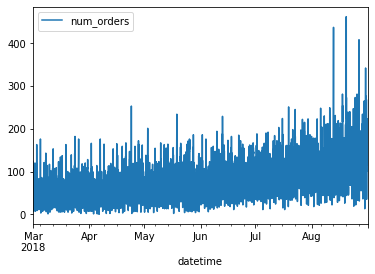

In [62]:
# Remuestreo con paso de tiempo de 1 hora 

data = data.resample('1H').sum()
data.plot()

In [63]:
data.isnull().sum()

num_orders    0
dtype: int64

### Conclusiones intermedias

1. Al cargar los datos usando los argumentos "index_col" y "parse_dates", los mismos quedaron prácticamente listos para el análisis.
2. El remuestreo de 1 hora de los datos se realizó utilizando una función de agregación ("sum()"), con el objetivo de conocer la cantidad de pedidos en este lapso de tiempo. Esto debido a que la modelación requiere conocer la cantidad de pedidos en la próxima hora. 

## Análisis

El análisis de la serie de tiempo examinará los siguientes aspectos:

1. Cálculo de media móvil para suavizar la serie.
2. Determinación de la tendencia y estacionalidad.
3. Identificación del tipo de serie (estacionaria o no estacionaria). En caso de que la serie sea no-estacionaria, se procederá con su transformación a estacionaria para poder realizar predicciones. 

### Media móvil

<AxesSubplot:xlabel='datetime'>

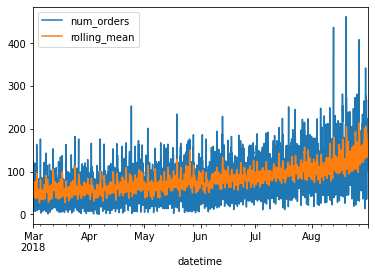

In [64]:
# Cálculo de media móvil

rolling = data.copy()
rolling['rolling_mean'] = rolling.rolling(10).mean()
rolling.plot()

In [65]:
data.isnull().sum()

num_orders    0
dtype: int64

In [66]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Ya con el cáculo de la media móvil se puede apreciar una ligera tendencia creciente en el número de pedidos entre los meses de Junio a Agosto. Sería interesante conocer en que país se encuentra la compañía para saber si estos meses corresponden a verano o invierno.

### Tendencia y estacionalidad

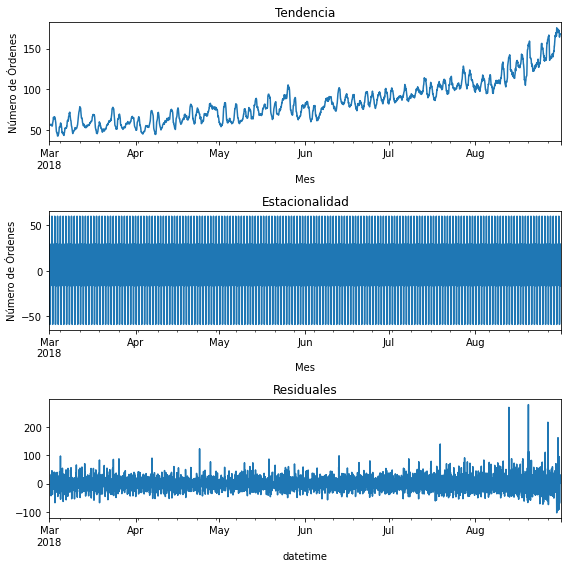

In [72]:
# Grafica tendencia, estacionalidad y ruido

decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.xlabel('Mes')
plt.ylabel('Número de Órdenes')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Mes')
plt.ylabel('Número de Órdenes')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout()    

El gráfico de tendencia nos permite confirmar que existe una tendencia creciente en el numero de órdenes con el paso de los meses. La cantidad de órdenes fluctúa entre aproximadamente 50 en marzo a 150 en septiembre.

Sin embargo, no se puede interpretar nada de la gráfica de estacionalidad debido a la escala temporal de los datos. Se graficará la estacionalidad por segmentos de tiempo para mejorar la interpretabilidad. Probaremos graficando el primer dia, primera semana y primer mes de la serie de tiempo.  

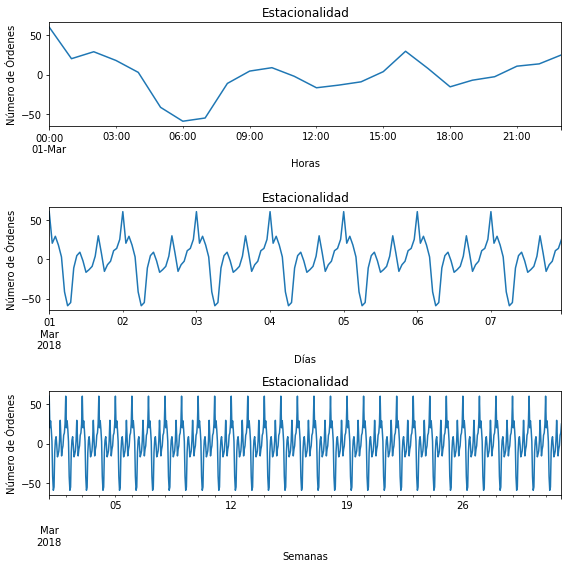

In [76]:
# Gráfica de estacionalidad por segmentos de tiempo 

plt.figure(figsize=(8, 8))

#Día
plt.subplot(311)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-01 23:00:00'].plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Horas')
plt.ylabel('Número de Órdenes')

#Semana
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-07 23:00:00'].plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Días')
plt.ylabel('Número de Órdenes')

#Mes
plt.subplot(313)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-31 23:00:00'].plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.xlabel('Semanas')
plt.ylabel('Número de Órdenes')

plt.tight_layout()

### Conclusiones intermedias

1. El gráfico de tendencia nos permite confirmar que existe una tendencia creciente en el numero de órdenes con el paso de los meses. La cantidad de órdenes fluctúa entre aproximadamente 50 en marzo a 150 en septiembre.

2. Los gráficos de estacionalidad nos permiten visualizar un claro patrón diario, que oscila entre -50 y 50, con su pico máximo a las 00:00 con 50 y un mínimo a las 06:00 de -50. A partir de esa hora, la tendencia es de un aumento paulatino del número de órdenes. Esto implica que la serie de tiempo es estacionaria, y que se pueden realizar predicciones a partir de la misma.  

## Ingeniería de carácterísticas

Para realizar el entrenamiento se deben crear características adicionales en los datos originales. Principalmente, se debe definir una característica asociada a nuestra variable objetivo que es la predicción del número de órdenes en la siguiente hora. Para esto se definará la función "make_features".

In [78]:
# Fucnión para la creación de características

def make_features(data, max_lag):
    
    """
    Esta función toma los datos originales y define carracterísticas 
    de calendario, desfase y variable objetivo 
    """
    
    # Crea las columnas con datos de año, mes, día y día de la semana
    data = data.copy(deep=True)
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Crea las columnas con los datos de desfase 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    #Crea la columna de la varaible objetivo
    data['next_hour'] = data['num_orders'].shift(-1)
    
    data = data.dropna()
    return data

modelling_data = make_features(data, 3)
modelling_data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,next_hour
datetime,,,,,,,,,
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,43.0
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,6.0
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,12.0
2018-03-01 06:00:00,12,2018,3,1,3,6.0,43.0,66.0,15.0
2018-03-01 07:00:00,15,2018,3,1,3,12.0,6.0,43.0,34.0


In [79]:
# Generación de conjuntos de entrenamiento y prueba

train, test = train_test_split(modelling_data, shuffle = False, test_size = 0.1)

features_train = train.drop('next_hour', axis = 1)
target_train = train['next_hour']
features_test = test.drop('next_hour', axis = 1)
target_test = test['next_hour']

# Comprobación de dimensiones

print('features_train size:', features_train.shape[0])
print('features_test size:', features_test.shape[0])
print('target_train size:', target_train.shape[0])
print('target_test size:', target_test.shape[0])

features_train size: 3970
features_test size: 442
target_train size: 3970
target_test size: 442


### Conclusiones intermedias

1. El paso más importante en la ingeniería de características en este proyecto, es la creación de la variable objetivo correspondiente al número de órdenes en la siguiente hora. 

## Prueba

Para la modelación de utilizará un modelo de regresión lineal, para la prueba de cordura, y el modelo de potenciación de gradiente "Light GBM".

### Regresión lineal

In [83]:
# Modelo de regresion lineal

lr_model = LinearRegression()

lr_model.fit(features_train, target_train)

lr_train_prediction = lr_model.predict(features_train)
print("RMSE para el conjunto de entrenamiento:", mean_squared_error(target_train, lr_train_prediction) ** 0.5)
 
lr_test_prediction = lr_model.predict(features_test)
print("RMSE para el conjunto de prueba:", mean_squared_error(target_test, lr_test_prediction) ** 0.5)

RMSE para el conjunto de entrenamiento: 30.548455880381542
RMSE para el conjunto de prueba: 52.71954436351824


In [85]:
# Modelo Light GBM

# Creación de instancia del modelo
lgb = LGBMRegressor()

# Creación de parámentros para ajuste del modelo
param = {
        'num_leaves': [10, 31],
    'learning_rate': [.01,.5],
    'max_depth': [-1,5]
}

# Definición de parámetros para la validación cruzada
gs = GridSearchCV(estimator=lgb,param_grid=param,scoring='neg_mean_squared_error')

#Ajuste del modelo
lgb_model = gs.fit(X=features_train, y=target_train)
print(lgb_model.best_params_, lgb_model.best_score_)

#Obtiene un diccionario con la información de los resultados
results = lgb_model.cv_results_
#Obtiene el mejor índice
best_index = lgb_model.best_index_

#Obtiene los resutlados
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (lgb_model.best_score_*-1)**0.5

print('Fit time:', fit_time)
print('Score time:', score_time)
print('RMSE:', RMSE)

{'learning_rate': 0.5, 'max_depth': 5, 'num_leaves': 10} -1055.0015450871872
Fit time: 0.3361967086791992
Score time: 0.006827259063720703
RMSE: 32.48078732246476


### Concluciones finales

1. El modelo lineal da como resultado un modelo sobreajustado, con un valor de RMSE de 52.72 para el conjunto de prueba. 
2. El resultado con el modelo "Light GBM" es significativamente mejor con un RMSE de 32.48, el mismo que cumple con las especificaciones del proyecto (obtener un RECM no superior a 48). 

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48